In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/data-001.csv')

#Удаление фичей, которые использоваться не будут
columns_to_remove = ['oaid_hash', 'banner_id0', 'rate0', 'g0', 'coeff_sum0', 'banner_id1', 'rate1', 'g1', 'coeff_sum1']
data = data.drop(columns=columns_to_remove)

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


###Анализ датасета

In [ ]:
# Анализ данных: выводит информацию об отсутствующих значениях, уникальных значениях и описательную статистику датасета
def print_analysis(data):
    data_copy = data.copy()
    print(f'Empty values: \n{data.isnull().sum()}')
    print(f'Unique values: \n{data.nunique()}')
    print(data_copy.describe())

# Визуализация ежедневного тренда: строит графики суммарного числа показов (impressions) и кликов (clicks) по дням
def plot_daily_trend(data):
    data_copy = data.copy()
    data_copy['date_time'] = pd.to_datetime(data_copy['date_time'])
    data_copy['date'] = data_copy['date_time'].dt.date
    daily_impressions = data_copy.groupby('date')['impressions'].sum()
    daily_clicks = data_copy.groupby('date')['clicks'].sum()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Impressions', color=color)
    ax1.plot(daily_impressions.index, daily_impressions, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Clicks', color=color)
    ax2.plot(daily_clicks.index, daily_clicks, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Daily Impressions and Clicks Trend')
    plt.show()

# Визуализация корреляционной матрицы
def plot_correlation(data):
    data_copy = data.copy()
    numeric_data = data_copy.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Визуализация кликов и показов по времени суток и дням недели
def plot_clicks_by_time(data):
    data_copy = data.copy()
    data_copy['date_time'] = pd.to_datetime(data_copy['date_time'])
    data_copy['time_of_day'] = pd.cut(data_copy['date_time'].dt.hour,
                                   bins=[0, 6, 12, 18, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                   right=False)
    data_copy['day_of_week'] = data_copy['date_time'].dt.day_name()

    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(x='time_of_day', y='clicks', data=data_copy, estimator=sum, order=['Night', 'Morning', 'Afternoon', 'Evening'], ci=None)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='time_of_day', y='impressions', data=data_copy.groupby('time_of_day')['impressions'].sum().reset_index(), color='orange')

    ax1.set_title('Clicks and Impressions by Time of Day')
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Total Clicks', color='blue')
    ax2.set_ylabel('Total Impressions', color='orange')
    plt.show()

    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(x='day_of_week', y='clicks', data=data_copy, estimator=sum,
                      order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ci=None)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='day_of_week', y='impressions', data=data_copy.groupby('day_of_week')['impressions'].sum().reset_index(), color='orange')

    ax1.set_title('Clicks and Impressions by Day of Week')
    ax1.set_xlabel('Day of Week')
    ax1.set_ylabel('Total Clicks', color='blue')
    ax2.set_ylabel('Total Impressions', color='orange')

    plt.show()

# Основная функция анализа: вызывает все вышеуказанные функции
def analysis(data):
    print_analysis(data)
    plot_daily_trend(data)
    plot_correlation(data)
    plot_clicks_by_time(data)

Empty values: 
date_time          0
zone_id            0
banner_id          0
campaign_clicks    0
os_id              0
country_id         0
impressions        0
clicks             0
dtype: int64
Unique values: 
date_time          604712
zone_id              3444
banner_id            1633
campaign_clicks       822
os_id                  11
country_id             17
impressions             1
clicks                  2
dtype: int64
            zone_id     banner_id  campaign_clicks         os_id  \
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07   
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.400000e+01  5.200000e+01     0.000000e+00  1.000000e+00   
50%    1.900000e+01  2.170000e+02     0.000000e+00  2.000000e+00   
75%    6.000000e+01  6.110000e+02     0.000000e+00  3.000000e+00   
max    3.443000e+03  1.

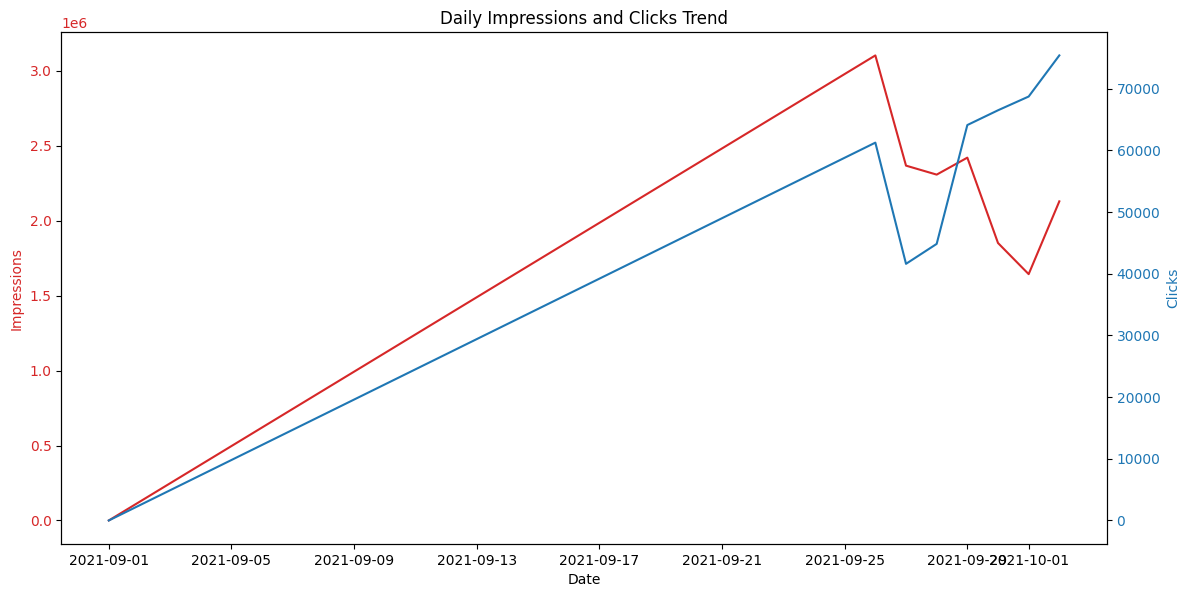

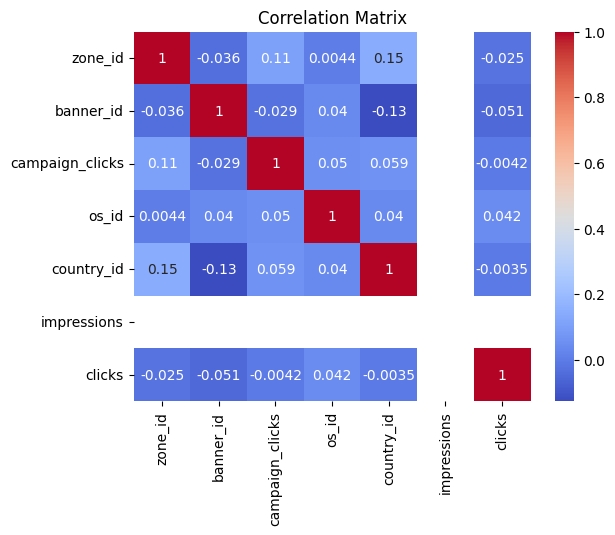

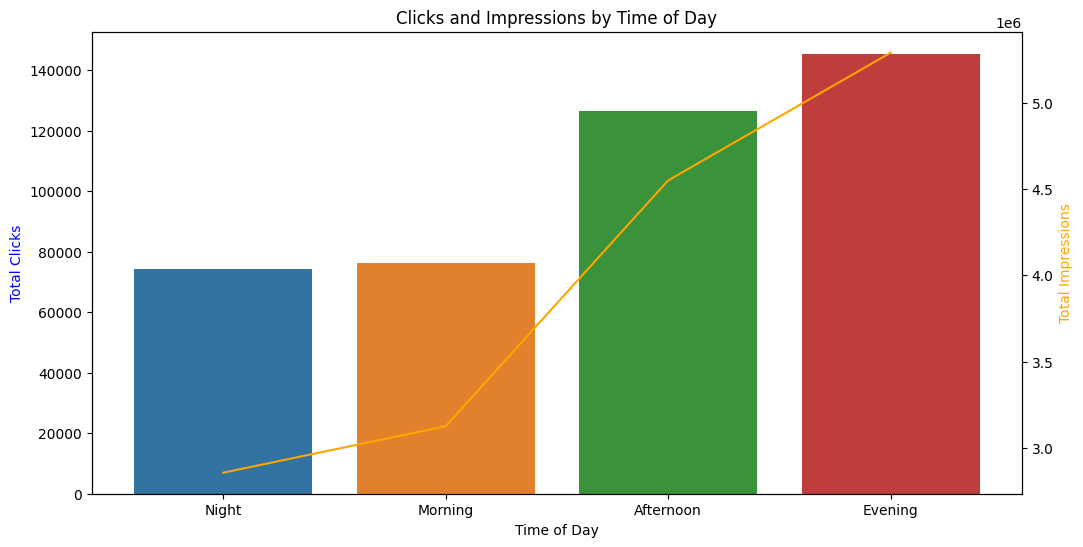

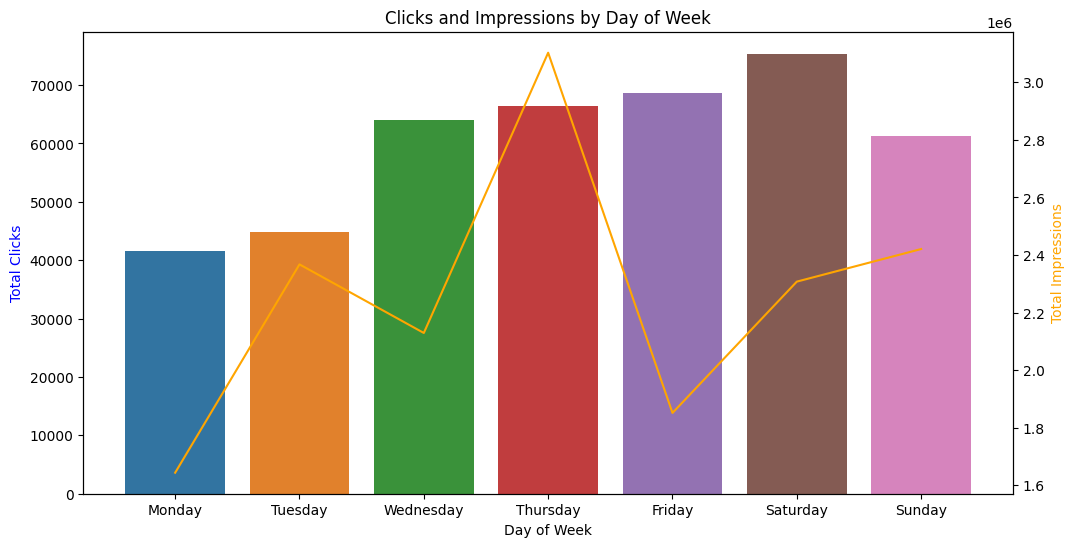

In [ ]:
analysis(data)

###Добавление фичей, One-Hot Encoding, деление на train/test

In [ ]:
def feature_engineering(data: pd.DataFrame) -> (pd.DataFrame, pd.Series, pd.DataFrame, pd.Series):
    # Удаление ненужных признаков
    data = data.drop(['impressions'], axis=1)

    # Фильтрация данных по времени
    data['date_time'] = pd.to_datetime(data['date_time'])

    # Добавление фичи "Время суток"
    data['time_of_day'] = pd.cut(data['date_time'].dt.hour,
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Добавление фичи "День недели"
    data['day_of_week'] = data['date_time'].dt.day_name()

    # One-Hot Encoding
    columns_to_encode = ['zone_id', 'banner_id', 'os_id', 'country_id', 'time_of_day', 'day_of_week']
    encoder = OneHotEncoder(drop='first', sparse=True)
    encoded_features = encoder.fit_transform(data[columns_to_encode])

    # Разделение на обучающий и тестовый наборы
    train_data = data[data['date_time'] < '2021-10-02']
    test_data = data[data['date_time'] >= '2021-10-02']

    x_train = train_data.drop(['clicks', 'date_time'], axis=1)
    x_train_encoded = encoder.transform(x_train[columns_to_encode])
    x_train = hstack([x_train.drop(columns=columns_to_encode).values, x_train_encoded])
    y_train = train_data['clicks']

    x_test = test_data.drop(['clicks', 'date_time'], axis=1)
    x_test_encoded = encoder.transform(x_test[columns_to_encode])
    x_test = hstack([x_test.drop(columns=columns_to_encode).values, x_test_encoded])
    y_test = test_data['clicks']

    return x_train, y_train, x_test, y_test


In [ ]:
x_train, y_train, x_test, y_test = feature_engineering(data)

### Создание модели, обучение, кросс валидация

In [ ]:
# Функция для создания модели
def create_model(solver):
    # Построение модели и подбор параметров регуляризации
    parameters = {'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']}
    lr = LogisticRegression(max_iter=10000, solver=solver)
    grid_search = GridSearchCV(lr, parameters, scoring=['neg_log_loss', 'roc_auc'], cv=5, verbose=2, refit='neg_log_loss')

    return grid_search

# Функция для обучения модели
def train_model(model, x_train, y_train):
    # Обучение модели
    model.fit(x_train, y_train)

    # Вывод параметров с лучшими результатами
    print("Best Parameters:", model.best_params_)
    best_lr_model = model.best_estimator_

    return best_lr_model

# Функция для вычисления метрик
def evaluate_model(model, x, y_true):
    y_pred_prob = model.predict_proba(x)[:, 1]
    logloss = log_loss(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    return logloss, auc


In [ ]:
model = create_model(solver='liblinear')
best_lr_model = train_model(model, x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................C=0.001, penalty=l1; total time= 3.0min
[CV] END ................................C=0.001, penalty=l1; total time= 3.1min
[CV] END ................................C=0.001, penalty=l1; total time= 2.4min
[CV] END ................................C=0.001, penalty=l1; total time= 2.9min
[CV] END ................................C=0.001, penalty=l1; total time= 2.0min
[CV] END ................................C=0.001, penalty=l2; total time= 1.0min
[CV] END ................................C=0.001, penalty=l2; total time=  55.8s
[CV] END ................................C=0.001, penalty=l2; total time= 1.0min
[CV] END ................................C=0.001, penalty=l2; total time=  57.3s
[CV] END ................................C=0.001, penalty=l2; total time=  55.5s
[CV] END .................................C=0.01, penalty=l1; total time= 5.8min
[CV] END .................................C=0.01,

###Оценка и сравнение с бейзлайном

In [ ]:
# Оценка модели на тестовых данных
logloss, auc = evaluate_model(best_lr_model, x_test, y_test)
print("Log Loss on test data:", logloss)
print("AUC on test data:", auc)

# Бейзлайн
mean_baseline = y_train.mean()
baseline_predictions = [mean_baseline] * len(y_test)
logloss_baseline = log_loss(y_test, baseline_predictions)
auc_baseline = roc_auc_score(y_test, baseline_predictions)
print("Log Loss baseline:", logloss_baseline)
print("AUC baseline:", auc_baseline)

Log Loss on test data: 0.13647059187763738
AUC on test data: 0.7687202651941554
Log Loss baseline: 0.15486198009919555
AUC baseline: 0.5
